# [Surprise](https://surprise.readthedocs.io/en/stable/index.html) 라이브러리 활용

- Collaborative Filtering 관련 머신러닝 라이브러리 Surprise를 사용해봅시다
- 본 패키지는 KNN Collaborative Filtering 외에도 Matrix Factorization 등의 알고리즘도 제공하지만, 본 실습에서는 KNN 알고리즘만 사용합니다

## 학습 데이터 준비

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633953 sha256=7aa4b33aed40c2e15c91af0cf86e669451dcc13115ab39ce5e8ece0be5a2584d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [6]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
import warnings
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans
from surprise.model_selection.validation import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive
from surprise import Reader, Dataset
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 학습 데이터가 들어있는 디렉토리 경로
path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/ml-latest-small-20220921T022859Z-001/ml-latest-small/'
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')

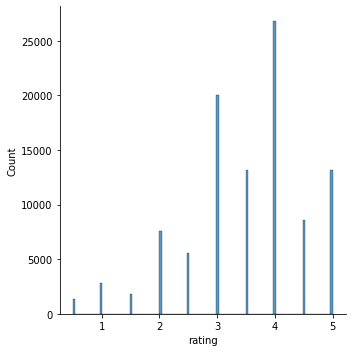

In [5]:
sns.displot(ratings_df['rating'])

In [7]:
# surprise에서 제공하는 dataset과 reader
# https://surprise.readthedocs.io/en/stable/reader.html
# https://surprise.readthedocs.io/en/stable/dataset.html
# Reader를 통해 평점 범위 확인
# Dataset을 통해 데이터를 형식에 맞게 변형
# --> 언제나 userId, movieId, rating의 순서로 Dataset에 넣어줘야함

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [8]:
type(data)

surprise.dataset.DatasetAutoFolds

## KNN Model

- [모델 API 문서](https://surprise.readthedocs.io/en/stable/knn_inspired.html)
- [유사도 API 문서](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration)

In [9]:
from surprise import accuracy
from surprise.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=10)

# 기본 KNN 모델 사용(UBCF)
# name(사용할 유사도의 종류) : cosine, pearson, MSD(default)
# user-based : True --> UBCF  / False --> IBCF

sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

knn_basic = KNNBasic(k=40, min_k=1, sim_options=sim_options) # k : 활용할 이웃의 수, min_k : 활용할 최소 이웃의 수

knn_basic.fit(train)
pred = knn_basic.test(test)

accuracy.rmse(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9699


0.969943918550271

In [10]:
len(pred)

20168

In [12]:
# surprise에서는 cross_validation 함수도 지원
user_based_cv_result = cross_validate(knn_basic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9660  0.9751  0.9777  0.9768  0.9663  0.9724  0.0051  
MAE (testset)     0.7462  0.7511  0.7520  0.7511  0.7441  0.7489  0.0032  
Fit time          0.37    0.35    0.36    0.35    0.35    0.36    0.01    
Test time         1.51    1.68    1.48    1.55    1.48    1.54    0.08    


In [13]:
# IBCF
sim_options = {
    'name' : 'cosine',
    'user_based' : False
}
knn_basic = KNNBasic(k=40, min_k=1, sim_options=sim_options)
knn_basic.fit(train)
pred = knn_basic.test(test)

accuracy.rmse(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765


0.9764701105938001

In [15]:
item_based_cv_result = cross_validate(knn_basic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9694  0.9763  0.9747  0.9810  0.9792  0.9761  0.0040  
MAE (testset)     0.7542  0.7616  0.7578  0.7640  0.7617  0.7599  0.0035  
Fit time          23.23   18.49   17.64   19.66   18.32   19.47   1.99    
Test time         8.13    8.64    9.51    8.06    8.56    8.58    0.52    


### KNN Model with deviation

- 평점을 예측할 때, 사용자 혹은 아이템의 평균평점을 고려하여 예측하는 모델
- predicted rating = average rating + predicted devaition

In [16]:
# KNNWithMeans
# UBCF
sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

knn_basic = KNNWithMeans(k=40, min_k=1, sim_options=sim_options)
knn_basic.fit(train)
pred = knn_basic.test(test)

accuracy.rmse(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9034


0.9033571267064436

In [17]:
# KNNWithMeans
# IBCF

sim_options = {
    'name' : 'cosine',
    'user_based' : False
}

knn_basic = KNNWithMeans(k=40, min_k=1, sim_options=sim_options)
knn_basic.fit(train)
pred = knn_basic.test(test)

accuracy.rmse(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9031


0.9030789845102651

### 여러가지 알고리즘, 하이퍼파라미터를 비교해봅시다
- 사용자가 정한 몇 개의 하이퍼파라미터의 가능한 경우의 수를 비교해보는 것을 그리드 서치라고 합니다
- 보통은 모델은 정해져 있고 거기에 사용되는 최적의 하이퍼파라미터를 찾는데 사용됩니다

In [18]:
# 이렇게 하지 말고 GridSearch를 사용하여 
# best_score 및 best_params를 뽑아낼수도 있다
benchmark = []

for algo in [KNNBasic(), KNNWithMeans()]:

  for k in [10, 20, 40]:
    for sim in ['cosine', 'msd', 'pearson']:
      for user_based in [True, False]:
        algo.k = k
        algo.sim_options = {'name' : sim, 'user_based' : user_based}
        results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

        rmse = results['test_rmse'].mean()
        benchmark.append([str(algo.__class__.__name__), k, sim, user_based, rmse])

benchmark_df = pd.DataFrame(benchmark,
                            columns = ['algorithm', 'k', 'similarity', 'user_based', 'rmse']
                           ).sort_values(by='rmse')

benchmark_df

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


,algorithm,k,similarity,user_based,rmse
33,KNNWithMeans,40,msd,False,0.893150
32,KNNWithMeans,40,msd,True,0.896793
34,KNNWithMeans,40,pearson,True,0.896849
26,KNNWithMeans,20,msd,True,0.899086
28,KNNWithMeans,20,pearson,True,0.899367
27,KNNWithMeans,20,msd,False,0.900660
30,KNNWithMeans,40,cosine,True,0.901573
24,KNNWithMeans,20,cosine,True,0.903436
35,KNNWithMeans,40,pearson,False,0.904064
31,KNNWithMeans,40,cosine,False,0.905191


## 추천 결과 서빙
- 위에서 수행한 오프라인 테스트 결과를 바탕으로 모델을 선택합니다
- 실제 프로덕션에 적용할 때는 train/test를 나누지 않고 지금까지 쌓인 모든 데이터를 가지고 학습하여 모델을 만듭니다

In [19]:
# 최고 성능 모델로 추천
# 실제 프로덕션 적용시 --> Full Dataset 사용

full_data = data.build_full_trainset()
sim_options = {
    'name' : 'msd',
    'user_based' : False
}

knn = KNNWithMeans(k=40, min_k=1, sim_options=sim_options)
knn.fit(full_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


- [predict method](https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict)

In [20]:
# user_1의 item_29에 대한 평점 예측
# est값이 모델 예측 평점
knn.predict(1, 29)  

Prediction(uid=1, iid=29, r_ui=None, est=4.900674110940887, details={'actual_k': 40, 'was_impossible': False})

In [22]:
# user_1에 대해 rating이 없는 영화들 가운데 추천
# 전체 영화 list에서 user_1이 이미 평가한 movieId는 제거
user_id = 1
candidate_itemlist = list(set(ratings_df['movieId'].unique()) \
                          - set(ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()))

len(candidate_itemlist)

9492

In [23]:
def recomm_highest_rating_from_user(user_id, item_ids, algo, k):
  '''
  user_id : 추천 대상 유저
  item_ids : 추천후보 아이템(유저가 평점을 남기지 않은 아이템)
  k : 예측 평점 기준으로 정렬 후 추천할 아이템 수
  '''
  _result = []

  for item_id in item_ids:
    pred_rating = algo.predict(user_id, item_id).est
    _result.append([item_id, pred_rating])
  
  # 예측 평점 기준 정렬 후 k개 리턴
  ratings = pd.DataFrame(_result, columns=['movieId', 'predRating']).sort_values(by='predRating', ascending=False)
  return ratings[:k]

recomm_highest_rating_from_user(user_id, candidate_itemlist, knn, 10)

,movieId,predRating
6400,164917,5.0
6316,107951,5.0
9468,98154,5.0
4577,71462,5.0
2627,3330,5.0
7136,147196,5.0
7138,147250,5.0
3114,3942,5.0
4585,5938,5.0
4595,5949,5.0


In [24]:
# 실제 서비스 --> 모든 item에 대해 예측 평점 구한 다음 정렬하는게 데이터가 많아 어려우므로 해당 방법을 쓰기도 함
def recomm_higher_than_threshold_from_user(user_id, item_ids, algo, k, threshold):
  '''
  1) shuffle 
  2) 평점 예측 후 예측한 평점이 threshold보다 높은 아이템들만 가져옴
  3) 만약 가져온 아이템 수가 k보다 많아지면, 해당 user의 item추천은 중단
  '''
  _result = []

  for item_id in item_ids:
    pred_rating = algo.predict(user_id, item_id).est
    
    if pred_rating >= threshold:
      _result.append([item_id, pred_rating])
    
    if len(_result) >= k:
      break
  
  ratings = pd.DataFrame(_result, columns=['movieId', 'predRating']).sort_values(by='predRating', ascending=False)
  return ratings

recomm_higher_than_threshold_from_user(user_id, candidate_itemlist, knn, k=10, threshold=4.5)

,movieId,predRating
6,28,5.000000
8,131098,5.000000
1,14,4.903461
7,29,4.900674
3,17,4.726863
5,25,4.691105
2,16,4.687966
0,11,4.679673
9,32,4.664150
4,18,4.625876
